In [58]:
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy.signal import savgol_filter
%matplotlib inline

In [59]:
import sys
np.set_printoptions(threshold=sys.maxsize)

In [60]:
disp_figs = True

In [113]:
M = 4 # Number of Spiking motifs
N = 10 # Number of input neurons
D = 31 # temporal depth of receptive field
T = 1000
dt = 1
nrn_fr = 100 # hz
pg_fr = 8 # hz
background_noise_fr = 0 # h

np.random.seed(41)

In [114]:
# for matplotlib
colors = np.array(['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'])
len(colors)

10

# Generate the PG Kernels


In [115]:
# I will try and do this with dense and sparse representations at the same time
# Dense K: matrix of binary images of sizeNxDxM
# Sparse K: set of (delay d, neuron a, and pg b)

K_dense = np.random.randint(0,999,(N,D,M))
K_dense[K_dense < nrn_fr] = 1
K_dense[K_dense >= nrn_fr] = 0
K_sparse = np.where(K_dense)

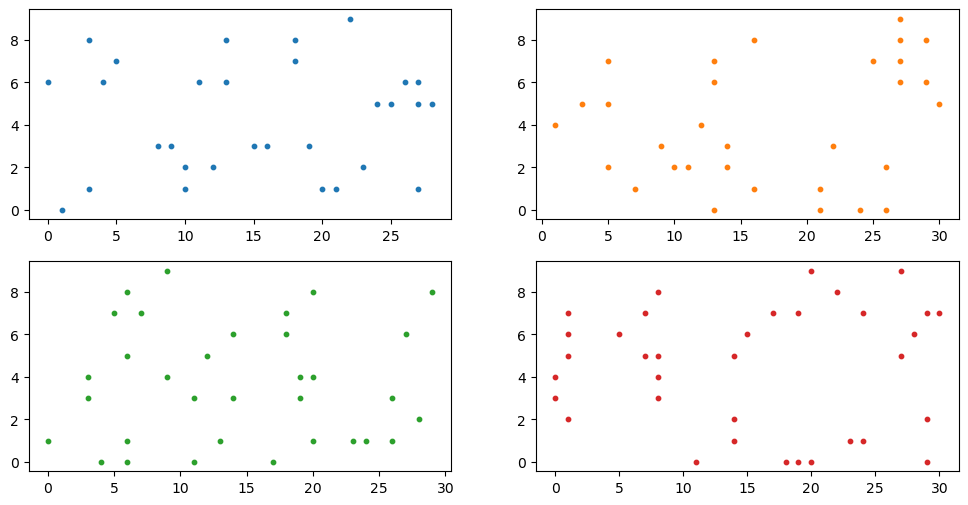

In [116]:

if disp_figs:
    %matplotlib inline
    fig,ax = plt.subplot_mosaic('AB;CD',figsize=(12,6))
    [ax[k].scatter(K_sparse[1][K_sparse[2]==i], K_sparse[0][K_sparse[2]==i],c=colors[i],s=10) for i,k in enumerate(['A','B','C','D'])]

# Generate the PG occurrences

In [117]:
# I suppose I can also do this in sparse and dense
# dense B: the binary image of the occurrences of the spiking motif as a ( M x T) matrix
# spare B: set of all times t and pg's b
B_dense = np.random.randint(0,999,(M,T))
B_dense[B_dense < pg_fr] = 1
B_dense[B_dense >= pg_fr] = 0
B_sparse = np.where(B_dense)

In [118]:
B_sparse[0]

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3,
       3, 3, 3, 3], dtype=int64)

In [119]:
colors[B_sparse[0]]

array(['#1f77b4', '#1f77b4', '#1f77b4', '#1f77b4', '#1f77b4', '#1f77b4',
       '#1f77b4', '#1f77b4', '#ff7f0e', '#ff7f0e', '#ff7f0e', '#ff7f0e',
       '#ff7f0e', '#ff7f0e', '#ff7f0e', '#2ca02c', '#2ca02c', '#2ca02c',
       '#2ca02c', '#2ca02c', '#d62728', '#d62728', '#d62728', '#d62728',
       '#d62728', '#d62728'], dtype='<U7')

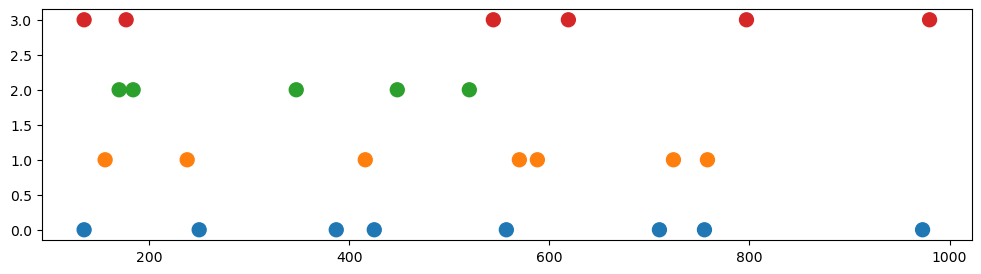

In [120]:
plt.figure(figsize=(12,3))
plt.scatter(B_sparse[1],B_sparse[0],c=colors[B_sparse[0]],s=100)
plt.show()

# Convolve the PG kernels with the PG firing times

In [121]:
background_noise_fr

0

In [122]:
# now to make the full raster plot keeping the labels in-tact
# dense A: the layered binary images of all neuron spikes by PG ( N x T x M
A_dense = np.zeros((N,T+D,M+1))
A_dense[...,-1] = np.random.randint(0,999,(N,T+D))
A_dense[...,-1] = (A_dense[...,-1] < background_noise_fr).astype('int')
for i in range(len(B_sparse[0])):
    t = B_sparse[1][i]
    b = B_sparse[0][i]
    A_dense[:, t:t+D, b] += K_dense[...,b]
    
A_dense.shape
# A_dense = A_dense[:,:1000,:]
A_sparse = np.where(A_dense)
A_dense = np.sum(A_dense,axis=2)
A_dense[A_dense>1] = 1
A_dense.shape

(10, 1031)

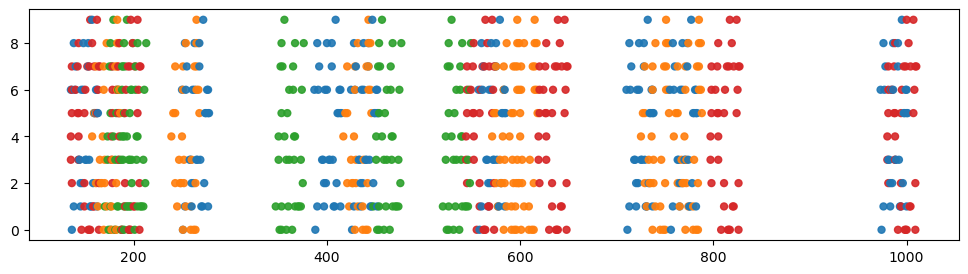

In [123]:
%matplotlib inline
plt.figure(figsize=(12,3))
plt.scatter(A_sparse[1],A_sparse[0],c=colors[A_sparse[2]],alpha=0.9,s=100,marker='.')
plt.show()

# Sanity Check

Let's start with a proof of concept by convolving the answers with the full raster plot :)

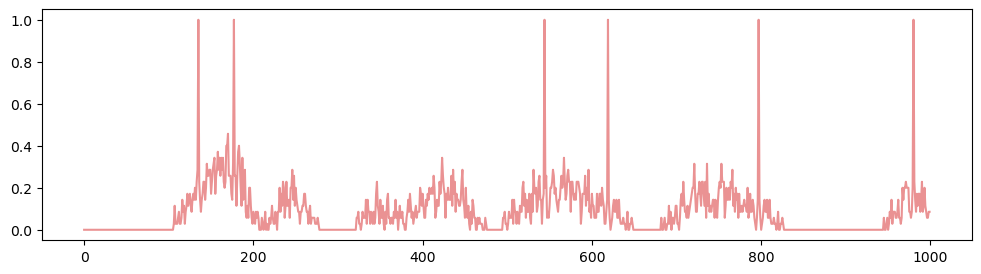

In [124]:
test = np.zeros((T,M))
%matplotlib inline
for j in range(M):
    for i in range(T):
        test[i,j] = np.sum(K_dense[...,j]*A_dense[:,i:i+D])
    test[:,j] = test[:,j]/np.max(test[:,j])
plt.figure(figsize=(12,3))
i = 3
plt.plot(test[:,i],color=colors[i],alpha=0.5)

# Unsupervised Learning

so... why don't I try the flawed window shift method? Even though this loses the spike information

In [125]:
window_dim = (int(np.ceil(D/2)), N)
valid_spikes = (A_sparse[1] > window_dim[0]) & (A_sparse[1] < T- window_dim[0])

In [126]:
window_times = A_sparse[1][valid_spikes]
# window_times

In [127]:
A_dense.shape

(10, 1031)

 should make sure to have the labels handy...

In [155]:
windows = np.zeros((len(window_times), N, window_dim[0]*2))
labels = A_sparse[2][valid_spikes]
for i,window_time in enumerate(window_times):
    windows[i,...] = A_dense[:,-window_dim[0]+window_time:window_dim[0]+window_time]
    windows[i,A_sparse[0][i],window_dim[0]] = 2
print('spikes: %d, neurons: %s, depth: %a' %windows.shape)

spikes: 781, neurons: 10, depth: 32


lets reshape windows 

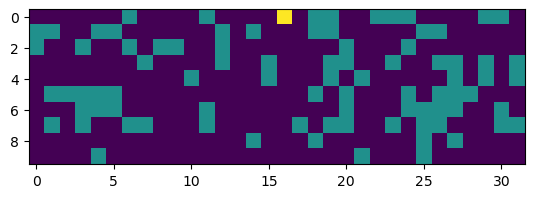

In [164]:
plt.figure()
plt.imshow(windows[7])

In [165]:
new_shape = (windows.shape[2]*windows.shape[1], windows.shape[0])
windows = np.reshape(windows,new_shape)
windows.shape

(320, 781)

now how can I do clustering on this data... hmmmm

In [166]:
import pandas as pd
from scipy.stats import zscore
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [167]:
z_windows = zscore(windows,axis=1)
z_windows[np.isnan(z_windows)] = 0
z_windows.shape

(320, 781)

In [168]:
M

4

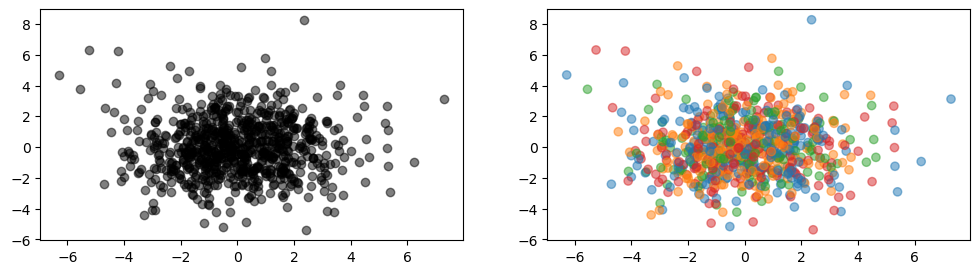

In [169]:

%matplotlib inline
pca = PCA(n_components=2)
pca_features2 = pca.fit_transform(np.transpose(z_windows))
pca_df = pd.DataFrame(data=pca_features2, columns=['PC1', 'PC2'])
fig,ax = plt.subplot_mosaic('AB',figsize=(12,3))
ax['A'].scatter(*pca_features2.T,c='black',alpha=0.5)
ax['B'].scatter(*pca_features2.T,c=colors[labels],alpha=0.5)
plt.show()

No clusters there... :(

In [170]:
%matplotlib qt
pca = PCA(n_components=3)
pca_features3 = pca.fit_transform(np.transpose(z_windows))
pca_df = pd.DataFrame(data=pca_features3, columns=['PC1', 'PC2','PC3'])
fig = plt.figure(figsize=(12,3))
ax[0] = fig.add_subplot(121, projection='3d')
ax[1] = fig.add_subplot(122, projection='3d')
ax[0].scatter(*pca_features3.T,c='black',alpha=0.5,s=10)
ax[1].scatter(*pca_features3.T,c=colors[labels],alpha=0.5,s=10)
plt.show()

In [171]:
z_windows.shape,len(z_windows)

((320, 781), 320)

In [172]:
%matplotlib inline
n_components=np.min(z_windows.shape)
pca = PCA(n_components=n_components)
pca_features3 = pca.fit_transform(z_windows.T)
columns=['PC%d'%i for i in range(1,1+n_components)]
pca_df = pd.DataFrame(data=pca_features3, columns=columns)
# print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

In [173]:
pca_features3.shape

(781, 320)

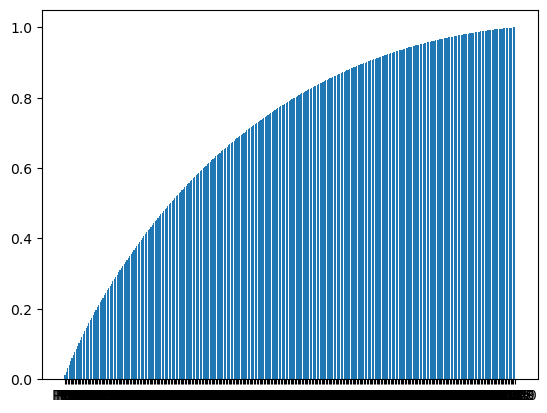

In [174]:
plt.figure()
plt.bar(columns,np.cumsum(pca.explained_variance_ratio_))
plt.show()

Lol that didn't help at all... :(

# tsne?

In [176]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import time

In [177]:
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(np.transpose(z_windows))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 781 samples in 0.012s...
[t-SNE] Computed neighbors for 781 samples in 0.132s...
[t-SNE] Computed conditional probabilities for sample 781 / 781
[t-SNE] Mean sigma: 4.554383
[t-SNE] KL divergence after 250 iterations with early exaggeration: 67.372025
[t-SNE] KL divergence after 300 iterations: 2.299500


In [180]:
tsne_results.shape, A_sparse[2][valid_spikes].shape

((781, 2), (781,))

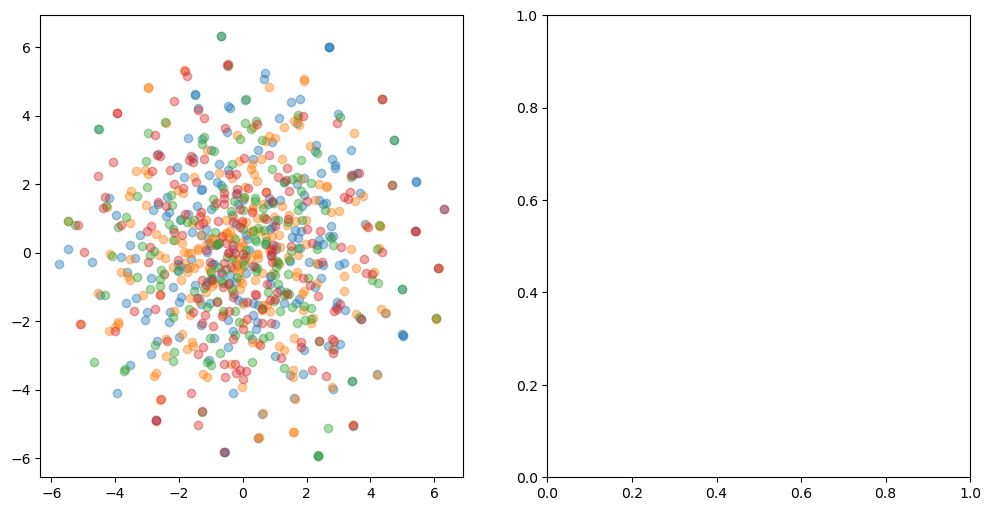

In [182]:
fig,ax = plt.subplot_mosaic('AB',figsize=(12,6))
[ax['A'].scatter(tsne_results[:,0][A_sparse[2][valid_spikes]==i], tsne_results[:,1][A_sparse[2][valid_spikes]==i],alpha=0.4) for i in range(8)]
# ax['A'].scatter(kmeans.cluster_centers_.T[0], kmeans.cluster_centers_.T[1],marker='X',color='black',s=100)

# [ax['B'].scatter(tsne_results[:,0][kmeans.labels_==i],tsne_results[:,1][kmeans.labels_==i]) for i in range(8)]
# ax['B'].scatter(kmeans.cluster_centers_.T[0], kmeans.cluster_centers_.T[1],marker='X',color='black',s=100)

plt.show()

bro those are some sweet clusters